# Crime and Weather-ment

Will certain weather conditions be statistically related to increases in crime?

In [86]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats



crime_2019=pd.read_csv("data/Crime_Data_2019.csv") #2019- 2021
louisville_weather=pd.read_csv("data/2451549.csv") #Weather from 1-1-1997 til 2-9-2021

# print(crime_2019.describe())

num_crime_reports = len(crime_2019)
print("The number of crime reports: ", num_crime_reports)

list_of_crime_types = crime_2019.CRIME_TYPE.unique()


total_counts = crime_2019['CRIME_TYPE'].value_counts()

# crime_2019


The number of crime reports:  148863


In [87]:
total_counts

ASSAULT                     31201
THEFT/LARCENY               26797
OTHER                       17429
DRUGS/ALCOHOL VIOLATIONS    14249
VEHICLE BREAK-IN/THEFT      13865
VANDALISM                   12096
BURGLARY                     9821
MOTOR VEHICLE THEFT          9136
FRAUD                        7413
ROBBERY                      2409
WEAPONS                      2092
SEX CRIMES                    999
DISTURBING THE PEACE          863
HOMICIDE                      288
ARSON                         198
DUI                             7
Name: CRIME_TYPE, dtype: int64

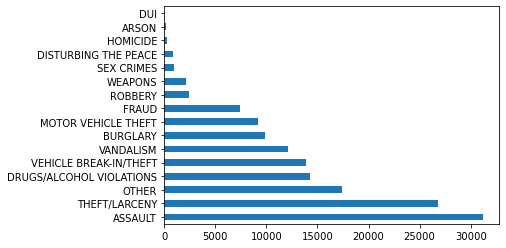

In [88]:
total_counts.plot.barh(x='Number of crimes' )

In [153]:
#Strips the time from date/time
crime_2019['DATE_OCCURED_NOTIME'] = crime_2019['DATE_OCCURED'].str.split(' ').str[0]
# crime_2019['DATE_OCCURED_NOTIME']
crime_2019['Report-Occur-Difference']= pd.to_datetime(crime_2019['DATE_REPORTED'].str.split(' ').str[0]) - pd.to_datetime(crime_2019['DATE_OCCURED'].str.split(' ').str[0])
crime_2019
number = crime_2019['Report-Occur-Difference'].dt.days.sum()
number = crime_2019['Report-Occur-Difference'].dt.days.max()
number = crime_2019['Report-Occur-Difference'].dt.days.mode()


number

0    0.0
dtype: float64

In [90]:
louisville_weather['PRCP'].describe()   #describe precipitation column
# louisville_weather['DATE']


count    8803.000000
mean        0.148638
std         0.400267
min         0.000000
25%         0.000000
50%         0.000000
75%         0.070000
max        10.480000
Name: PRCP, dtype: float64

In [91]:
# louisville_weather.describe()
louisville_weather.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'MDPR',
       'MDPR_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SNOW', 'SNOW_ATTRIBUTES',
       'SNWD', 'SNWD_ATTRIBUTES', 'TMAX', 'TMAX_ATTRIBUTES', 'TMIN',
       'TMIN_ATTRIBUTES', 'TOBS', 'TOBS_ATTRIBUTES', 'WESD', 'WESD_ATTRIBUTES',
       'WT01', 'WT01_ATTRIBUTES', 'WT03', 'WT03_ATTRIBUTES', 'WT04',
       'WT04_ATTRIBUTES', 'WT05', 'WT05_ATTRIBUTES', 'WT06', 'WT06_ATTRIBUTES',
       'WT11', 'WT11_ATTRIBUTES'],
      dtype='object')

In [92]:
date_crime_count_df = louisville_weather[['DATE','PRCP','SNOW','TMAX','TMIN']].iloc[8035:8766]
date_crime_count_df['DOW'] = pd.to_datetime(date_crime_count_df['DATE']).dt.day_name()
date_crime_count_df['DOW-N'] = pd.to_datetime(date_crime_count_df['DATE']).dt.dayofweek  #DOW-Number 0=Monday, 1=Tuesday...

date_crime_count_df['Day'] = pd.to_datetime(date_crime_count_df['DATE']).dt.day
date_crime_count_df['Month'] = pd.to_datetime(date_crime_count_df['DATE']).dt.month
date_crime_count_df['Year'] = pd.to_datetime(date_crime_count_df['DATE']).dt.year


date_crime_count_df

,DATE,PRCP,SNOW,TMAX,TMIN,DOW,DOW-N,Day,Month,Year
8035,2019-01-01,0.00,0.0,53.0,41.0,Tuesday,1,1,1,2019
8036,2019-01-02,0.00,0.0,43.0,39.0,Wednesday,2,2,1,2019
8037,2019-01-03,0.00,0.0,43.0,35.0,Thursday,3,3,1,2019
8038,2019-01-04,0.69,0.0,46.0,35.0,Friday,4,4,1,2019
8039,2019-01-05,0.01,0.0,56.0,35.0,Saturday,5,5,1,2019
...,...,...,...,...,...,...,...,...,...,...
8761,2020-12-27,0.00,0.0,57.0,30.0,Sunday,6,27,12,2020
8762,2020-12-28,0.00,0.0,53.0,28.0,Monday,0,28,12,2020
8763,2020-12-29,0.00,0.0,39.0,29.0,Tuesday,1,29,12,2020
8764,2020-12-30,1.00,0.0,58.0,34.0,Wednesday,2,30,12,2020


In [93]:
#Take all of the crime types for the day, count them, and put them in a series to be connected to the specific day
crime_series=[]
assault_series=[]
theft_series=[]
other_series=[]
drugs_series=[]
vehicle_break_series=[]
vandalism_series=[]
burglary_series=[]
motor_vehicle_theft_series=[]
fraud_series=[]
robbery_series=[]
weapons_series=[]
sex_crimes_series=[]
disturbing_peace_series=[]
homicide_series=[]
arson_series=[]
dui_series=[]

for date in date_crime_count_df['DATE']:
    crime_series.append((crime_2019['DATE_OCCURED_NOTIME']==date).sum())
    assault_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="ASSAULT") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    theft_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="THEFT/LARCENY") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    other_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="OTHER") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    drugs_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="DRUGS/ALCOHOL VIOLATIONS") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    vehicle_break_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="VEHICLE BREAK-IN/THEFT") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    vandalism_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="VANDALISM") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    burglary_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="BURGLARY") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    motor_vehicle_theft_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="MOTOR VEHICLE THEFT") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    fraud_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="FRAUD") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    robbery_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="ROBBERY") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    weapons_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="WEAPONS") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    sex_crimes_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="SEX CRIMES") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    disturbing_peace_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="DISTURBING THE PEACE") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    homicide_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="HOMICIDE") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    arson_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="ARSON") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))
    dui_series.append(len(crime_2019[(crime_2019['CRIME_TYPE']=="DUI") & (crime_2019['DATE_OCCURED_NOTIME']==date)]))


# print(sum(dui_series))
# print(sum(arson_series))
# print(sum(homicide_series))


In [94]:
date_crime_count_df['NUMBER_OF_CRIMES'] = crime_series
date_crime_count_df['ASSAULT'] = assault_series
date_crime_count_df['THEFT'] = theft_series
date_crime_count_df['OTHER'] = other_series
date_crime_count_df['DRUGS'] = drugs_series
date_crime_count_df['VEHICLE BREAKINS'] = vehicle_break_series
date_crime_count_df['VANDALISM'] = vandalism_series
date_crime_count_df['BURGLARY'] = burglary_series
date_crime_count_df['MOTOR VEHICLE THEFT'] = motor_vehicle_theft_series
date_crime_count_df['FRAUD'] = fraud_series
date_crime_count_df['ROBBERY'] = robbery_series
date_crime_count_df['WEAPONS'] = weapons_series
date_crime_count_df['SEX CRIMES'] = sex_crimes_series
date_crime_count_df['DISTURBING PEACE'] = disturbing_peace_series
date_crime_count_df['HOMICIDE'] = homicide_series
date_crime_count_df['ARSON'] = arson_series
date_crime_count_df['DUI'] = dui_series



In [95]:
date_crime_count_df

,DATE,PRCP,SNOW,TMAX,TMIN,DOW,DOW-N,Day,Month,Year,...,BURGLARY,MOTOR VEHICLE THEFT,FRAUD,ROBBERY,WEAPONS,SEX CRIMES,DISTURBING PEACE,HOMICIDE,ARSON,DUI
8035,2019-01-01,0.00,0.0,53.0,41.0,Tuesday,1,1,1,2019,...,24,12,17,5,8,13,2,1,0,0
8036,2019-01-02,0.00,0.0,43.0,39.0,Wednesday,2,2,1,2019,...,9,8,10,1,8,1,1,0,0,0
8037,2019-01-03,0.00,0.0,43.0,35.0,Thursday,3,3,1,2019,...,10,5,15,2,9,0,0,0,0,0
8038,2019-01-04,0.69,0.0,46.0,35.0,Friday,4,4,1,2019,...,18,6,9,4,4,1,1,0,0,0
8039,2019-01-05,0.01,0.0,56.0,35.0,Saturday,5,5,1,2019,...,14,13,14,3,6,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,2020-12-27,0.00,0.0,57.0,30.0,Sunday,6,27,12,2020,...,6,12,3,3,2,1,1,1,0,0
8762,2020-12-28,0.00,0.0,53.0,28.0,Monday,0,28,12,2020,...,11,15,12,6,9,0,1,0,1,0
8763,2020-12-29,0.00,0.0,39.0,29.0,Tuesday,1,29,12,2020,...,10,22,9,2,3,0,1,1,0,0
8764,2020-12-30,1.00,0.0,58.0,34.0,Wednesday,2,30,12,2020,...,12,15,5,1,3,0,0,2,0,0


In [131]:
date_crime_count_df['DOW'] = date_crime_count_df['DOW'].astype(str)

In [97]:
print(date_crime_count_df.dtypes)

DATE                    object
PRCP                   float64
SNOW                   float64
TMAX                   float64
TMIN                   float64
DOW                     object
DOW-N                    int64
Day                      int64
Month                    int64
Year                     int64
NUMBER_OF_CRIMES         int64
ASSAULT                  int64
THEFT                    int64
OTHER                    int64
DRUGS                    int64
VEHICLE BREAKINS         int64
VANDALISM                int64
BURGLARY                 int64
MOTOR VEHICLE THEFT      int64
FRAUD                    int64
ROBBERY                  int64
WEAPONS                  int64
SEX CRIMES               int64
DISTURBING PEACE         int64
HOMICIDE                 int64
ARSON                    int64
DUI                      int64
dtype: object


In [98]:
# date_crime_count_df['PRCP'].describe()
zero_days = (date_crime_count_df['PRCP']==0).sum()
nonzero_days = (date_crime_count_df['PRCP']>0).sum()
print("Number of days with no precipitation: ",zero_days, " - Percentage: ", zero_days/(zero_days+nonzero_days))  # How many zeros are there
print("Number of days with some precipitation: ", nonzero_days, " - Percentage: ", nonzero_days/(zero_days+nonzero_days))
print("Number of days with snow: ", (date_crime_count_df['SNOW']>0).sum())

Number of days with no precipitation:  439  - Percentage:  0.600547195622435
Number of days with some precipitation:  292  - Percentage:  0.399452804377565
Number of days with snow:  22


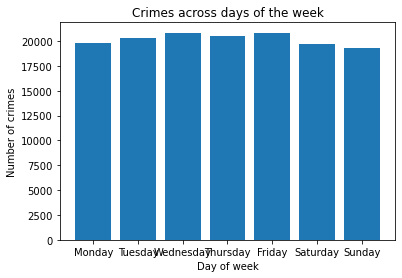

In [127]:
monday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Monday', 'NUMBER_OF_CRIMES'].sum()
tuesday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Tuesday', 'NUMBER_OF_CRIMES'].sum()
wednesday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Wednesday', 'NUMBER_OF_CRIMES'].sum()
thursday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Thursday', 'NUMBER_OF_CRIMES'].sum()
friday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Friday', 'NUMBER_OF_CRIMES'].sum()
saturday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Saturday', 'NUMBER_OF_CRIMES'].sum()
sunday_crimes = date_crime_count_df.loc[date_crime_count_df['DOW'] == 'Sunday', 'NUMBER_OF_CRIMES'].sum()


x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
DOW = [monday_crimes, tuesday_crimes, wednesday_crimes, thursday_crimes, friday_crimes, saturday_crimes, sunday_crimes]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, DOW)
plt.xlabel("Day of week")
plt.ylabel("Number of crimes")
plt.title("Crimes across days of the week")

plt.xticks(x_pos, x)

plt.show()


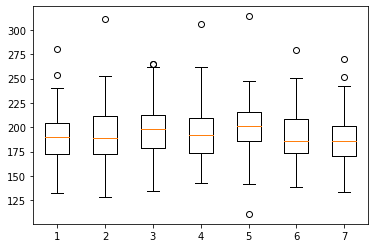

In [136]:
DOW=[]
DOWList=['Monday', 'Tuesday','Wednesday', 'Thursday','Friday','Saturday', 'Sunday']
for x in DOWList:
    DOW.append(date_crime_count_df.loc[date_crime_count_df['DOW'] == x, 'NUMBER_OF_CRIMES'])

averageCrimesOnDOM= plt.boxplot(DOW)

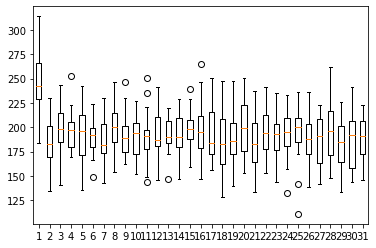

In [101]:
DOM=[]
for x in range(1,32):
    DOM.append(date_crime_count_df.loc[date_crime_count_df['Day'] == x, 'NUMBER_OF_CRIMES'])


averageCrimesOnDOM= plt.boxplot(DOM)



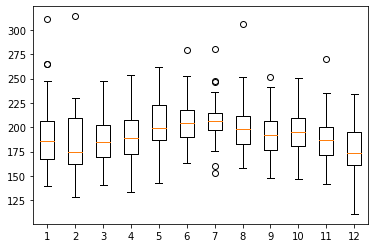

In [102]:
MOY=[]
for x in range(1,13):
    MOY.append(date_crime_count_df.loc[date_crime_count_df['Month'] == x, 'NUMBER_OF_CRIMES'])


averageCrimesOnMOY= plt.boxplot(MOY)



[72753, 68508]


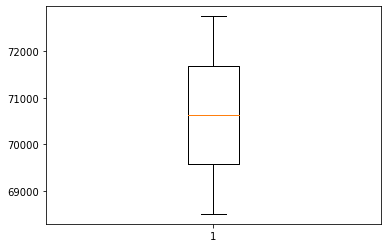

In [130]:
Year=[]
yearList=[2019,2020]
for x in yearList:
    Year.append(date_crime_count_df.loc[date_crime_count_df['Year'] == x, 'NUMBER_OF_CRIMES'].sum())

print(Year)

averageCrimesOnYear= plt.boxplot(Year)

.00-.19 “very weak”

.20-.39 “weak”

.40-.59 “moderate”

.60-.79 “strong”

.80-1.0 “very strong”


(-0.11627888398448699, 0.0016375082173144219)


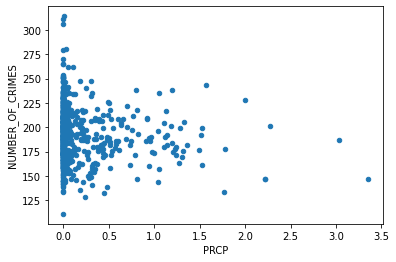

In [103]:
#What is the correlation between precipitation amounts and number of crimes per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['NUMBER_OF_CRIMES']))
#precipitation/crimes
date_crime_count_df.plot(x='PRCP', y='NUMBER_OF_CRIMES', kind='scatter', )

(-0.1251550364087384, 0.0006954402585593036)


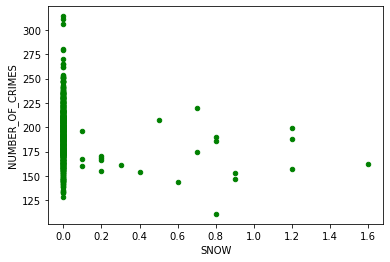

In [104]:
#What is the correlation between snow amounts and number of crimes per day
print(stats.pearsonr(date_crime_count_df['SNOW'],date_crime_count_df['NUMBER_OF_CRIMES']))
#Scatter plot for snow and number of crimes
date_crime_count_df.plot(x='SNOW', y='NUMBER_OF_CRIMES', kind='scatter', color='green', )

(0.2981289052130566, 1.800050733230918e-16)


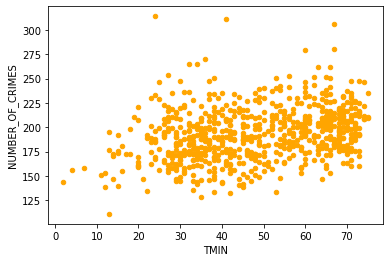

In [105]:
#What is the correlation between TMIN and number of crimes per day
print(stats.pearsonr(date_crime_count_df['TMIN'],date_crime_count_df['NUMBER_OF_CRIMES']))
date_crime_count_df.plot(x='TMIN', y='NUMBER_OF_CRIMES', kind='scatter', color='orange', )

(0.30472422856089904, 3.5787839285259404e-17)


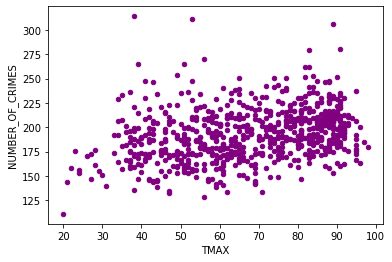

In [106]:
#What is the correlation between TMAX and number of crimes per day
print(stats.pearsonr(date_crime_count_df['TMAX'],date_crime_count_df['NUMBER_OF_CRIMES']))
date_crime_count_df.plot(x='TMAX', y='NUMBER_OF_CRIMES', kind='scatter', color='purple', )

(0.40131654837873626, 1.1608098097953829e-29)


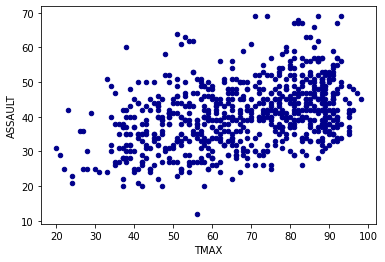

In [107]:
#What is the correlation between TMAX and number of assaults per day
print(stats.pearsonr(date_crime_count_df['TMAX'],date_crime_count_df['ASSAULT']))
date_crime_count_df.plot(x='TMAX', y='ASSAULT', kind='scatter', color='darkblue', )

(-0.07505213715041026, 0.0425016398350216)


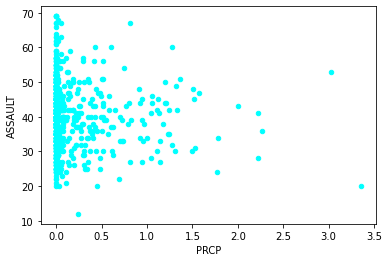

In [108]:
#What is the correlation between Precipitation and assaults per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['ASSAULT']))
date_crime_count_df.plot(x='PRCP', y='ASSAULT', kind='scatter', color='aqua', )

(-0.007916895195455591, 0.8307917525050307)


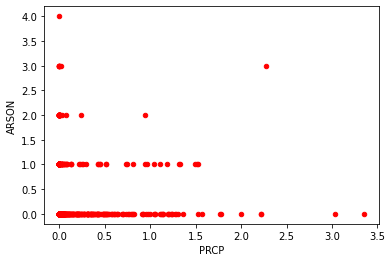

In [109]:
#What is the correlation between Precipitation and arsons per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['ARSON']))
date_crime_count_df.plot(x='PRCP', y='ARSON', kind='scatter', color='red', )

(0.00846247167260333, 0.8193255864454945)


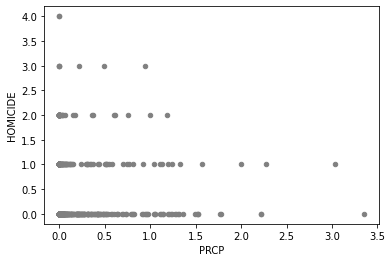

In [110]:
#What is the correlation between Precipitation and Homicides per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['HOMICIDE']))
date_crime_count_df.plot(x='PRCP', y='HOMICIDE', kind='scatter', color='grey', )

(-0.02978623140076134, 0.4213213670708609)


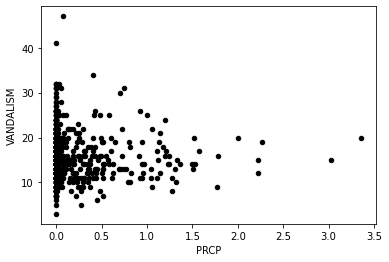

In [111]:
#What is the correlation between Precipitation and vandalisms per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['VANDALISM']))
date_crime_count_df.plot(x='PRCP', y='VANDALISM', kind='scatter', color='black', )

(-0.04580993002618637, 0.21605236703301192)


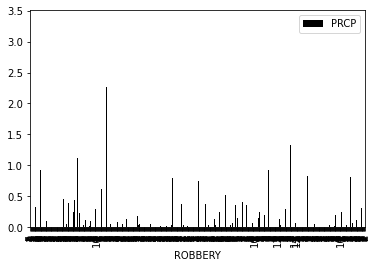

In [112]:
#What is the correlation between Precipitation and robbery per day
print(stats.pearsonr(date_crime_count_df['PRCP'],date_crime_count_df['ROBBERY']))
date_crime_count_df.plot(x='ROBBERY', y='PRCP', kind='bar', color='black', )